# UCI Poker dataset classification with Pandas, Matplotlib and Scikit-learn

***

We will be using UCI Poker dataset in this kernel.

Start by importing needed packages.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:

from sklearn.tree import DecisionTreeClassifier


# Load data
Let's load data to Pandas dataframes and take a firts look at it.

In [4]:
test = pd.read_csv('poker-hand-testing.data', header=None)

In [5]:
test.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1,1,1,13,2,4,2,3,1,12,0
1,3,12,3,2,3,11,4,5,2,5,1
2,1,9,4,6,1,4,3,2,3,9,1
3,1,4,3,13,2,13,2,1,3,6,1
4,3,10,2,7,1,2,2,11,4,9,0


In [7]:
train = pd.read_csv('poker-hand-training-true.data', header=None)

In [8]:
train.columns = ['S1', 'C1','S2', 'C2','S3', 'C3','S4', 'C4','S5', 'C5','Label']

In [9]:
test.columns = ['S1', 'C1','S2', 'C2','S3', 'C3','S4', 'C4','S5', 'C5','Label']

In [10]:
test.head()

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,Label
0,1,1,1,13,2,4,2,3,1,12,0
1,3,12,3,2,3,11,4,5,2,5,1
2,1,9,4,6,1,4,3,2,3,9,1
3,1,4,3,13,2,13,2,1,3,6,1
4,3,10,2,7,1,2,2,11,4,9,0


In [11]:
train.head()

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,Label
0,1,10,1,11,1,13,1,12,1,1,9
1,2,11,2,13,2,10,2,12,2,1,9
2,3,12,3,11,3,13,3,10,3,1,9
3,4,10,4,11,4,1,4,13,4,12,9
4,4,1,4,13,4,12,4,11,4,10,9


In [12]:
train.shape

(25010, 11)

In [13]:
test.shape

(1000000, 11)

# Extract features and labels

In [14]:
X_train = train.loc[:,train.columns != 'Label']

In [15]:
X_test = test.loc[:,test.columns != 'Label']

In [16]:
Y_train = train['Label']

In [17]:
Y_test = test['Label']

# Label distribution in train set

In [18]:
Y_train.groupby(Y_train).size()

Label
0    12493
1    10599
2     1206
3      513
4       93
5       54
6       36
7        6
8        5
9        5
Name: Label, dtype: int64

# Label distribution in test set

In [19]:
Y_test.groupby(Y_test).size()

Label
0    501209
1    422498
2     47622
3     21121
4      3885
5      1996
6      1424
7       230
8        12
9         3
Name: Label, dtype: int64

# Define helper functions

In [20]:
def preprocess_data(data:pd.DataFrame):
    df = data.copy()
    dfc = df[['C1', 'C2', 'C3', 'C4', 'C5']]
    dfc.values.sort()
    df[['C1', 'C2', 'C3', 'C4', 'C5']] = dfc
    df = df[['C1', 'C2', 'C3', 'C4', 'C5', 'S1', 'S2', 'S3', 'S4', 'S5', 'Label']]
    return df

In [21]:
def add_counts(df:pd.DataFrame):
    tmp = df[['C1', 'C2', 'C3', 'C4', 'C5']]
    df['Cnt_C1'] = tmp.apply(lambda x: sum(x==x[0]) ,axis=1)
    df['Cnt_C2'] = tmp.apply(lambda x: sum(x==x[1]) ,axis=1)
    df['Cnt_C3'] = tmp.apply(lambda x: sum(x==x[2]) ,axis=1)
    df['Cnt_C4'] = tmp.apply(lambda x: sum(x==x[3]) ,axis=1)
    df['Cnt_C5'] = tmp.apply(lambda x: sum(x==x[4]) ,axis=1)
    
    tmp = df[['S1', 'S2', 'S3', 'S4', 'S5']]
    df['Cnt_S1'] = tmp.apply(lambda x: sum(x==x[0]) ,axis=1)
    df['Cnt_S2'] = tmp.apply(lambda x: sum(x==x[1]) ,axis=1)
    df['Cnt_S3'] = tmp.apply(lambda x: sum(x==x[2]) ,axis=1)
    df['Cnt_S4'] = tmp.apply(lambda x: sum(x==x[3]) ,axis=1)    
    df['Cnt_S5'] = tmp.apply(lambda x: sum(x==x[4]) ,axis=1)

In [22]:
def add_diffs(df:pd.DataFrame):
    df['Diff1'] = df['C5'] - df['C4']
    df['Diff2'] = df['C4'] - df['C3']
    df['Diff3'] = df['C3'] - df['C2']
    df['Diff4'] = df['C2'] - df['C1']

In [23]:
def add_unique_count(df:pd.DataFrame):
    tmp = df[['S1', 'S2', 'S3', 'S4', 'S5']]
    df['UniqueS'] = tmp.apply(lambda x: len(np.unique(x)) , axis=1)

In [24]:
def cross_validation(alg, X_train, Y_train, folds=10):
    kf = KFold(n_splits = folds, shuffle=True)

    acc = []
    matrix = None
    first = True

    i = 1
    for train_index, test_index in kf.split(X_train, Y_train):
        print('{}-Fold'.format(i))
        fX_train, fX_test = X_train.iloc[train_index,:], X_train.iloc[test_index,:]
        fy_train, fy_test = Y_train[train_index], Y_train[test_index]
        alg.fit(fX_train, fy_train)
        fy_pred = alg.predict(fX_test)
        curr = accuracy_score(fy_test, fy_pred, normalize=True)
        acc.append(curr)
        i = i+1

    acc = pd.Series(acc)
    return acc.mean()

# First try with Decision tree classifier

In [25]:
alg = DecisionTreeClassifier(random_state=1)

In [26]:
alg.fit(X_train, Y_train)

DecisionTreeClassifier(random_state=1)

In [27]:
y_pred = alg.predict(X_test)

In [29]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, y_pred, normalize=True)

0.479239

That's pretty low accuracy for a purely deterministic task as this one.

# Preprocess data

## Sorting values
If we take a look at poker hands in this dataset, we will see that cards in these hands are out of order.

First step at preprocessing is sorting cards in each hand, we will use function *preprocess_data* defined above.

In [30]:
X_train_pre = preprocess_data(train)

In [31]:
X_test_pre = preprocess_data(test)

In [32]:
X_train = X_train_pre.loc[:,X_train_pre.columns != 'Label']

In [33]:
X_test = X_test_pre.loc[:,X_test_pre.columns != 'Label']

Let's give it another try.

# 10-fold CV

In [35]:
from sklearn.model_selection import KFold
alg = DecisionTreeClassifier(random_state=1, criterion='gini')
cross_validation(alg, X_train, Y_train)

1-Fold
2-Fold
3-Fold
4-Fold
5-Fold
6-Fold
7-Fold
8-Fold
9-Fold
10-Fold


0.9564574170331868

In [36]:
alg = DecisionTreeClassifier(random_state=1, criterion='gini')
alg.fit(X_train, Y_train)
y_pred = alg.predict(X_test)
accuracy_score(Y_test, y_pred, normalize=True)

0.960249

96% accuracy is pretty neat, we are almost two times better after sorting cards in hands.

Now we will take a look at cases where our classifier performs poorly.

In [37]:
pd.crosstab(y_pred, Y_test, rownames=['Predicted'], colnames=['True'], margins=True)

True,0,1,2,3,4,5,6,7,8,9,All
Predicted,,,,,,,,,,,
0,494264,2631,5,19,0,1864,0,0,0,0,498783
1,1556,408995,11216,1870,300,1,70,4,0,0,424012
2,0,9361,35858,490,153,0,440,23,0,0,46325
3,0,845,232,17664,0,0,619,144,0,0,19504
4,0,507,73,12,3004,0,0,0,12,0,3608
5,5389,24,0,0,0,131,0,0,0,0,5544
6,0,125,238,1012,0,0,285,14,0,0,1674
7,0,0,0,54,0,0,10,45,0,0,109
8,0,10,0,0,292,0,0,0,0,0,302


In [38]:
pred_series = pd.Series(y_pred).groupby(y_pred).size()
true_series = pd.Series(Y_test.values).groupby(Y_test).size()
pred_res = pd.DataFrame()
pred_res['TrueLabel'] = true_series
pred_res['PredictedLabel'] = pred_series

In [39]:
pred_res

,TrueLabel,PredictedLabel
Label,,
0,501209,498783
1,422498,424012
2,47622,46325
3,21121,19504
4,3885,3608
5,1996,5544
6,1424,1674
7,230,109
8,12,302


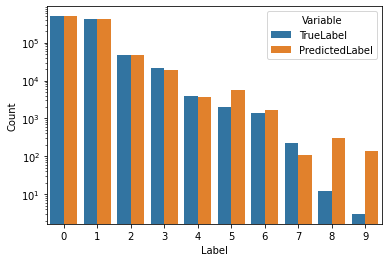

In [40]:
f, ax = plt.subplots()
ax.set(yscale="log")
sns.barplot(data=pred_res.stack().reset_index().rename(columns={0: 'Count', 'level_1': 'Variable'}), x='Label', y='Count', hue='Variable')

There is clearly problem with prediction of flushes and straight/royal flushes. We add new feature called *UniqueS* which contains number of unique suites of cards in hand.

In [41]:
add_unique_count(X_test)

In [42]:
add_unique_count(X_train)

In [43]:
alg = DecisionTreeClassifier(random_state=1, criterion='gini')
cross_validation(alg, X_train, Y_train)

1-Fold
2-Fold
3-Fold
4-Fold
5-Fold
6-Fold
7-Fold
8-Fold
9-Fold
10-Fold


0.9601759296281489

In [44]:
alg = DecisionTreeClassifier(random_state=1, criterion='gini')
alg.fit(X_train, Y_train)
y_pred = alg.predict(X_test)
accuracy_score(Y_test, y_pred, normalize=True)

0.965003

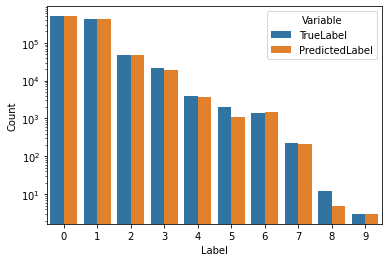

In [45]:
pred_series = pd.Series(y_pred).groupby(y_pred).size()
true_series = pd.Series(Y_test.values).groupby(Y_test).size()
pred_res = pd.DataFrame()
pred_res['TrueLabel'] = true_series
pred_res['PredictedLabel'] = pred_series
f, ax = plt.subplots()
ax.set(yscale="log")
sns.barplot(data=pred_res.stack().reset_index().rename(columns={0: 'Count', 'level_1': 'Variable'}), x='Label', y='Count', hue='Variable')

CV accuracy is slightly better, although straight flushes get under-predicted, but problem with flushes is solved.

Now we will add new features with values of differences between consecutive cards in hand.

In [46]:
add_diffs(X_train)

In [47]:
add_diffs(X_test)

In [48]:
alg = DecisionTreeClassifier(random_state=1, criterion='gini')
cross_validation(alg, X_train, Y_train)

1-Fold
2-Fold
3-Fold
4-Fold
5-Fold
6-Fold
7-Fold
8-Fold
9-Fold
10-Fold


0.9998000799680128

In [49]:
alg = DecisionTreeClassifier(random_state=1, criterion='gini')
alg.fit(X_train, Y_train)
y_pred = alg.predict(X_test)
accuracy_score(Y_test, y_pred, normalize=True)

0.999904

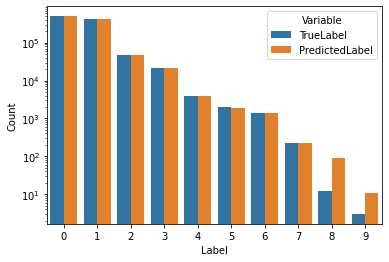

In [50]:
pred_series = pd.Series(y_pred).groupby(y_pred).size()
true_series = pd.Series(Y_test.values).groupby(Y_test).size()
pred_res = pd.DataFrame()
pred_res['TrueLabel'] = true_series
pred_res['PredictedLabel'] = pred_series
f, ax = plt.subplots()
ax.set(yscale="log")
sns.barplot(data=pred_res.stack().reset_index().rename(columns={0: 'Count', 'level_1': 'Variable'}), x='Label', y='Count', hue='Variable')

In [51]:
pd.crosstab(y_pred, Y_test, rownames=['Predicted'], colnames=['True'], margins=True)

True,0,1,2,3,4,5,6,7,8,9,All
Predicted,,,,,,,,,,,
0,501209,0,0,0,0,0,0,0,0,0,501209
1,0,422498,0,0,0,0,0,0,0,0,422498
2,0,0,47622,0,0,0,0,0,0,0,47622
3,0,0,0,21121,0,0,0,0,0,0,21121
4,0,0,0,0,3885,0,0,0,0,0,3885
5,0,0,0,0,0,1906,0,0,6,0,1912
6,0,0,0,0,0,0,1424,0,0,0,1424
7,0,0,0,0,0,0,0,230,0,0,230
8,0,0,0,0,0,82,0,0,6,0,88


Now we have really great accuracy of 99.99%, it's clear that out model somehow badly predicts straight flushes, but the rest is ok.

Decision tree performed better than expected, but we can try other classifiers as well.

# Test data evaluation

Let's do final test data evaluation with Decision tree classifier which had best accuracy among all tested classifiers.

In [52]:
alg = DecisionTreeClassifier(criterion='gini', random_state=111)

In [53]:
alg.fit(X_train, Y_train)

DecisionTreeClassifier(random_state=111)

In [54]:
y_pred = alg.predict(X_test)

In [55]:
accuracy_score(y_pred=y_pred, y_true=Y_test, normalize=True)

0.999944

# Feature importances

In [56]:
feature_imp = pd.DataFrame(sorted(zip(X_train.columns, alg.feature_importances_), key=lambda k: k[1], reverse=True))
feature_imp.columns = ['Feature', 'Importance']

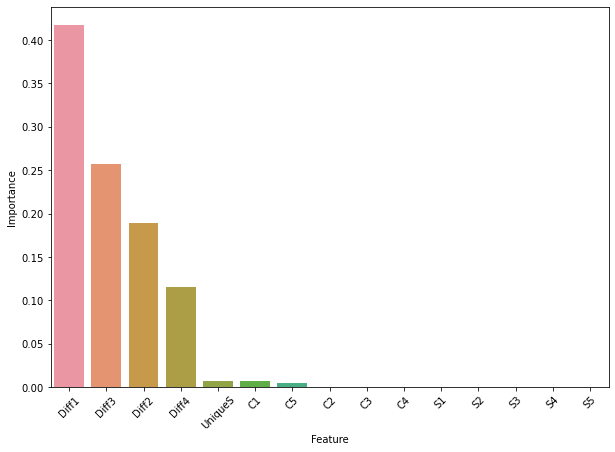

In [57]:
f, ax = plt.subplots(figsize=(10, 7))
# ax.set(yscale="log")
plt.xticks(rotation=45)
sns.barplot(data=feature_imp, x='Feature', y='Importance')

It's clear from the feature importance plot that classifier almost exclusively uses newly engineered features and original features like suites

That's all folks!

Your feedback is highly appreciated :)